## Test Welch's method vs. FFT

In [1]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch, psd_array_multitaper, tfr_array_multitaper, tfr_array_morlet
from scipy.signal import spectrogram
from scipy.signal import hilbert  # Apply Hilbert transform
from scipy.signal import butter, filtfilt, hilbert

#### 임의의 테스트 신호를 생성하고, 이 신호의 파워 스펙트럼 밀도(PSD)를 두 가지 방법으로 비교
- 1. 직접 FFT 사용
- 2. Welch's method 사용

In [2]:
rng = np.random.default_rng() 

# 사인파 주파수: 10 Hz
# 샘플링 주파수: 500 Hz → Nyquist limit = 250 Hz
# 길이: 100,000 샘플 → 200초 분량
# 노이즈 파워 스펙트럼 밀도: 0.001 V²/Hz

# Generate a test signal with 2 Vrms sine wave at 1234 Hz, corrupted by 0.001 V^2/Hz of white noise sampled at 10 kHz
fs = 500    # 샘플링 주파수 (500 Hz)
N = 1e5     # 샘플 개수 (100,000)
amp = 2*np.sqrt(2)  # 2 Vrms → peak amplitude = 2√2
freq = 10   # 주파수 10 Hz
noise_power = 0.001 * fs / 2    # White noise power
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)   # 순수한 사인파
x += rng.normal(scale=np.sqrt(noise_power), size=time.shape)    # 노이즈 추가

Display the signal in time domain(시간 영역에서 신호 표시시)

Estimate the power spectral density using FFT and Welch's methods(FFT 및 Welch의 방법을 사용하여 전력 스펙트럼 밀도 추정)

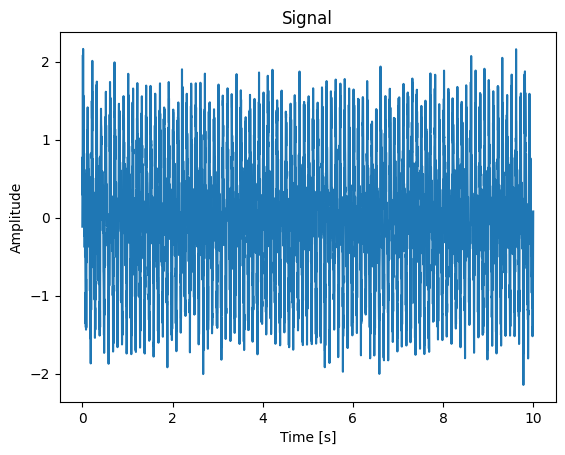

In [5]:
# 수정하면서 그래프 변환해보기

# 총 샘플 수 = 500 * 10 = 5000개
# t는 0초부터 10초까지 0.002초 간격으로 이루어진 시간 벡터
fs = 500    # 샘플링 주파수 (Hz)
T = 10      # 신호 길이 (초)    
t = np.linspace(0, T, int(fs * T), endpoint=False)

# 10Hz와 20Hz 성분이 섞인 합성 사인파에 노이즈가 섞인 구조
# 현실적인 측정 신호의 예시
signal = (
    np.sin(2*np.pi*10*t)    # 10Hz 사인파
    + 0.5*np.sin(2*np.pi*20*t)  # 20Hz 사인파 (진폭 0.5)
    + 0.3*np.random.randn(len(t)))  # 가우시안 노이즈 (표준편차 0.3)

# 10초짜리 신호를 전체 시계열로 시각화한 것
# 그림에서도 중간중간 패턴이 있고 노이즈가 포함된 구조로 보임
plt.plot(t, signal)
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

[그래프 분석]: 시간 영역
- 1. 시간 범위
    - 0초 ~ 10초 범위의 연속적인 신호를 나타냄.
    - 총 샘플 수는 5000개로, 샘플링 주파수 500Hz 기준 10초 길이의 신호.
- 2. 신호 구성 요소
    - 10Hz 사인파: 기본적인 진동 패턴을 형성
    - 20Hz 사인파: 진폭이 0.5로 상대적으로 약하며, 고주파 성분을 추가
    - 0.3*np.random.randn(...): 가우시안 노이즈로 인해 신호에 불규칙성이 있음
- 3. 그래프의 형태
    - 대략 ±2.5V 범위의 진폭을 가짐.
    - 규칙적이면서도 불규칙한 패턴을 보임 → 두 개의 주파수 성분이 중첩되었고, 랜덤 노이즈가 전체에 퍼져 있음.
    - 주기적인 패턴이 눈에 확연히 드러나진 않지만, 전반적으로 고주파 성분이 섞여 있는 느낌을 줌.

[해석 요점]
- 기본 성분: 10Hz 사인파 -> 느린 파동의 골격 형성
- 고주파 성분: 20Hz 사인파(진폭 0.5) -> 파형에 잔진동 추가
- 노이즈 영향: 표준편차 0.3의 노이즈가 전체 파형을 불규칙하게 만듦
- 신호 특성: 다소 혼란스러워 보이지만 저주파 + 고주파 + 노이즈 구조가 잘 섞여 있음

#### Full FFT 기반 PSD vs Welch's Method 기반 PSD

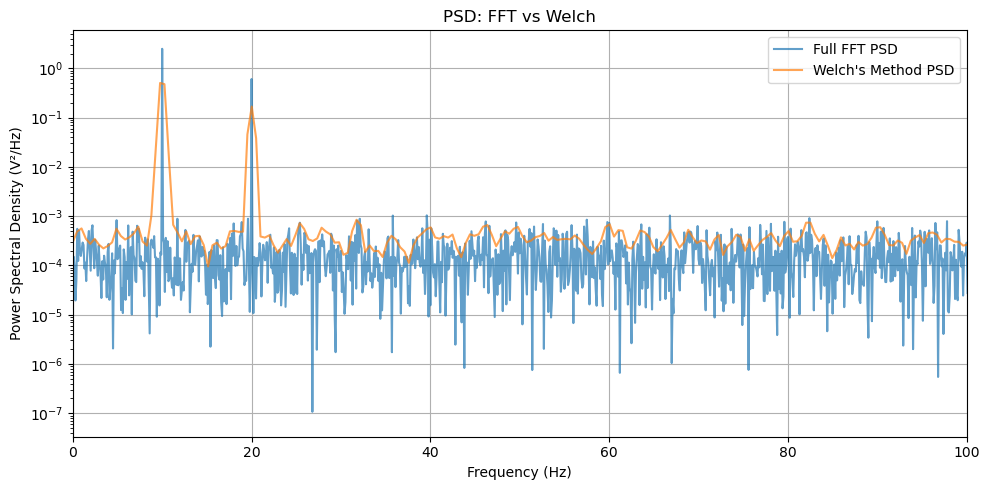

In [ ]:
# -----------------------------
# Full FFT
# -----------------------------
N = len(signal) # N: 신호의 총 샘플 수 (5000)
fft_vals = np.fft.fft(signal)   # np.fft.fft(signal): 신호 전체에 대한 FFT 계산 → 복소수 형태의 주파수 성분
fft_freqs = np.fft.fftfreq(N, 1/fs) # np.fft.fftfreq(N, 1/fs): 각 FFT 성분에 해당하는 실제 주파수 (Hz)

# FFT는 대칭 구조를 가지므로, 양의 주파수 부분만 추출
pos_mask = fft_freqs >= 0
fft_vals = fft_vals[pos_mask]
fft_freqs = fft_freqs[pos_mask]

# Power Spectral Density 계산 공식: |FFT|² / (fs × N)
# 단위는 V²/Hz
# log 스케일에 잘 어울리는 정규화된 PSD
# PSD: |FFT|^2 / (fs * N)
psd_fft = (np.abs(fft_vals) ** 2) / (fs * N)

# -----------------------------
# Welch's metthod
# -----------------------------
# welch: 여러 segment(1024개 샘플)로 나누고 각 세그먼트에 대해 FFT → 평균화
# 결과적으로 더 부드럽고 안정적인 PSD 곡선 생성
# f_welch: 주파수 벡터, psd_welch: Welch 추정 PSD
f_welch, psd_welch = welch(signal, fs=fs, nperseg=1024)

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(10, 5))
plt.semilogy(fft_freqs, psd_fft, label='Full FFT PSD', alpha=0.7)
plt.semilogy(f_welch, psd_welch, label="Welch's Method PSD", alpha=0.7)
plt.xlim([0, 100])
plt.title('PSD: FFT vs Welch')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[그래프 분석]
- 파란색 FFR PSD: 노이즈로 인한 높은 요동이 보임
- 주황색 Welch PSD: 부드럽고 안정적인 커브, 10Hz, 20Hz 피크가 선명하게 표현
- 1. X축 (Frequency in Hz)
    - 0부터 100Hz까지의 주파수 범위를 나타냄.
    - 이 신호는 500Hz로 샘플링되었기 때문에 최대 Nyquist 주파수는 250Hz지만, 시각화는 100Hz까지만 잘라서 비교함.
- 2. Y축 (Power Spectral Density, V²/Hz)
    - 로그 스케일 (semilogy)로 표시됨
    - 값이 작을수록 노이즈이고, 값이 큰 부분은 신호의 주요 주파수 성분을 의미함

[주요 피크 분석]
- 10Hz:
    - 가장 높은 peak가 존재함
    - 원래 신호에 포함된 사인파의 주 주파수로서, 잘 검출됨
- 20Hz:
    - 그 다음으로 큰 피크
    = 원래 신호에 포함된 진폭 0.5짜리 사인파 성분이 명확히 확인됨
- 이 두 피크는 **신호 생성 시 설정한 구성 요소(10Hz, 20Hz)**와 정확히 일치함.

[결론]
- 두 방법 모두 신호의 주요 주파수 성분(10Hz, 20Hz)을 잘 찾아냄
- Welch 방법은 더 부드럽고 신뢰도 있는 PSD 추정을 제공함
- FFR는 빠르지만 노이즈 영향이 큼, 분석 시 시각적 해석에는 부적절할 수 있음

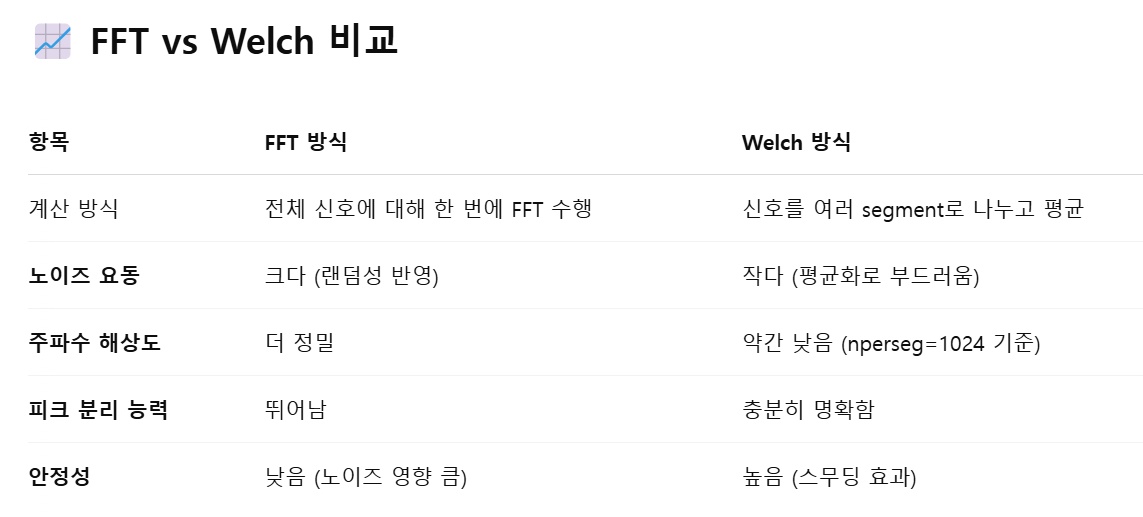

#### non-stationary signal (비정상 신호)을 시각화

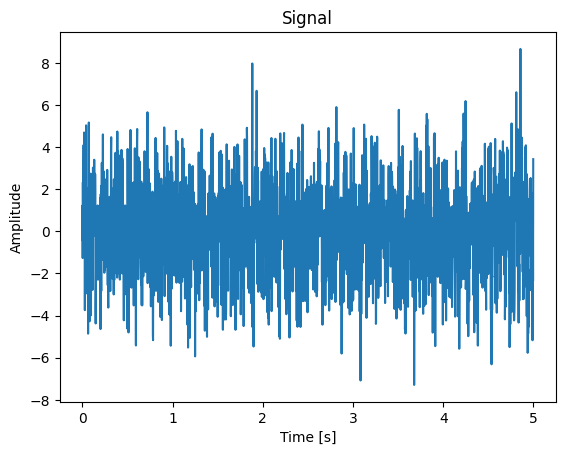

In [23]:
# 0초부터 5초까지 500Hz로 샘플링 → 총 2500개 샘플
fs = 500
T = 5 
t = np.linspace(0, T, int(fs*T), endpoint=False)

# 신호가 시간에 따라 바뀜:
#   0 ~ 4.5초: 10Hz, 진폭 1
#   4.5 ~ 5.0초: 20Hz, 진폭 2 → 더 높은 주파수와 더 큰 진폭
# Non-stationary signal
signal = np.zeros_like(t)
signal[t < 4.5] = np.sin(2*np.pi*10*t[t < 4.5]) 
signal[t >= 4.5] = 2 * np.sin(2*np.pi*20*t[t >= 4.5])    

# 표준편차 2.0의 노이즈 추가
# 굉장히 큰 노이즈이기 때문에 신호가 많이 흐트러져 있음
signal += 2.0 * np.random.randn(len(t))   \
# signal += 0.1 * np.random.randn(len(t))                

plt.plot(t, signal)
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

[그래프 분석]
- 1. 신호 패턴
    - 0초 ~ 4.5초:
        - 진폭이 작고 **주기적 패턴(10Hz)**이 보이긴 하지만, 강한 노이즈로 인해 흐릿하게 보임
        - 사인파 구조는 존재하지만, 노이즈가 그 위에 마구 얹혀진 느낌
    - 4.5초 ~ 5.0초:
        = 진폭이 확 커짐 (최대 8 이상)
        = 주기 역시 빨라져서 20Hz 성분의 진동이 더 짧은 간격으로 등장
- 2. 노이즈 영향
    - 노이즈가 매우 크기 때문에 시각적으로 명확한 주기성은 거의 보이지 않음
    - 그럼에도 불구하고, 마지막 0.5초 구간에서는 진폭이 크기 때문에 진동이 더 뚜렷하게 보임

[결론]
- 이 신호는 비정상(non-stationary) 특성 -> 시간에 따라 주파수/진폭이 변함
- 노이즈가 크지만, 시간-주파수 분석(SRFT, Wavelet)을사용하면 이 구조를 더 명확히 볼 수 있음
- 단순한 FFT나 Welch는 전체 평균이 되기 때문에 이런 신호에는 적합하지 않음

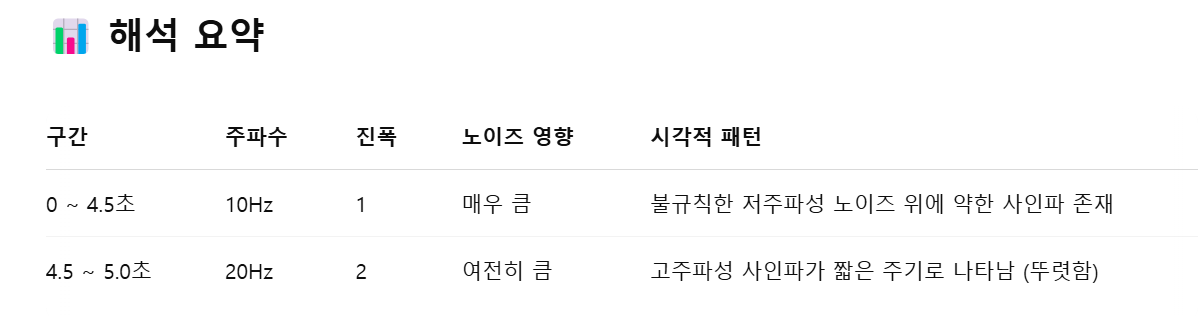

#### 비정상 신호에 대해 세 가지 방법으로 파워 스펙트럼 밀도(PSD)를 추정한 결과 비교
- Full FFT 방식
- Welch's Method
- Multitaper Method (다중 테이퍼 방법)

    Using multitaper spectrum estimation with 19 DPSS windows


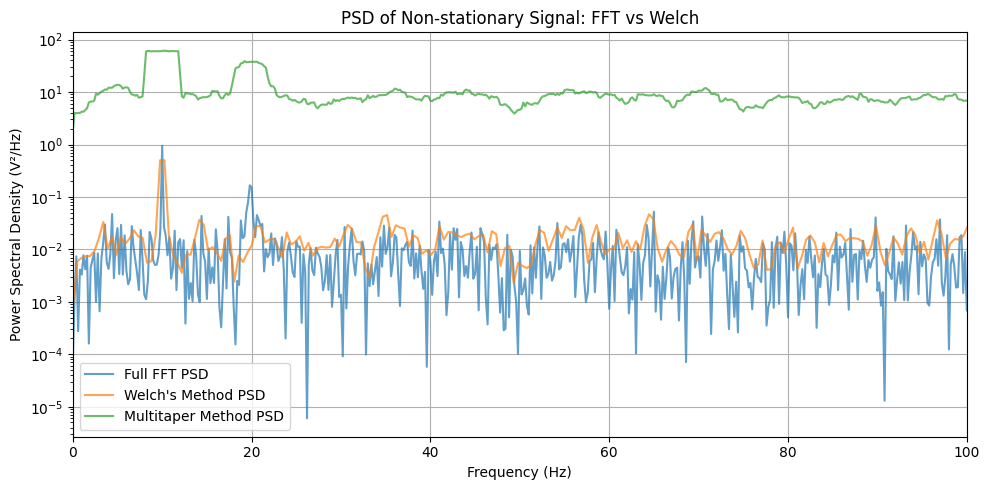

In [24]:
# Full FFT PSD
# 전체 신호를 한 번에 변환 → 정밀하긴 하나 비정상성 정보 손실
# pos_mask로 양의 주파수만 선택
N = len(signal)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(N, 1/fs)
pos_mask = fft_freqs >= 0
psd_fft = (np.abs(fft_vals[pos_mask]) ** 2) / (fs * N)

# Welch PSD
# 신호를 여러 구간(nperseg)으로 나눈 뒤, 각 구간에 대해 FFT → 평균
# 노이즈 감소 효과는 있음. 하지만 비정상성은 시간축에서 평균됨
f_welch, psd_welch = welch(signal, fs=fs, nperseg=1024)

# Multitaper PSD
# Multitaper는 다양한 **직교 tapers (Slepian sequences)**를 곱해서 평균하는 방식
# 스펙트럼 누출(spectral leakage)을 줄이고, 해상도와 안정성의 균형을 잡음
# bandwidth=4.0은 스펙트럼 추정 시 인접 주파수에 얼마만큼 영향을 주는지 조절
fmin, fmax = 0, fs/2
psd_mt, f_mt = psd_array_multitaper(signal, sfreq=fs, fmin=fmin, fmax=fmax, bandwidth=4.0)
# psd_mt, f_mt = psd_array_multitaper(signal, sfreq=fs, fmin=fmin, fmax=fmax, bandwidth=2.0)

# Visualization
plt.figure(figsize=(10, 5))
plt.semilogy(fft_freqs[pos_mask], psd_fft, label='Full FFT PSD', alpha=0.7)
plt.semilogy(f_welch, psd_welch, label="Welch's Method PSD", alpha=0.7)
plt.semilogy(f_mt, psd_mt, label="Multitaper Method PSD", alpha=0.7)
plt.title('PSD of Non-stationary Signal: FFT vs Welch')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.xlim([0, 100])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



[그래프 분석]
- X축: 주파수 (0 ~ 100 Hz)
    - 이 신호의 두 주요 성분(10 Hz, 20 Hz)이 있는 영역을 포함하고 있음
- Y축: Power Spectral Density (log scale)
    - 로그 스케일로 시각화 → 작은 값도 잘 보이게 함

[주파수 해석]
- 10 Hz 근방:
    - 모든 방법에서 에너지 집중됨.
    - Welch와 Multitaper 모두 명확한 peak 감지 가능.
- 20 Hz 근방:
    - FFT는 잘 포착하나 요동이 심함
    - Welch는 peak 높이가 다소 낮음
    - Multitaper는 peak가 더 넓고 평평하게 퍼짐 → 이유는 해당 주파수 성분이 **짧은 시간(0.5초)**만 존재했기 때문

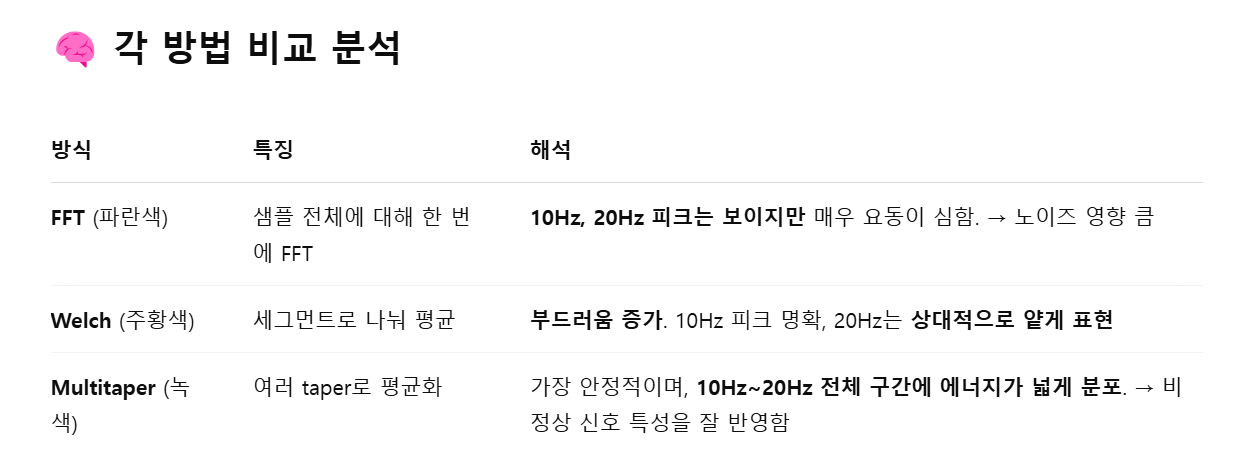
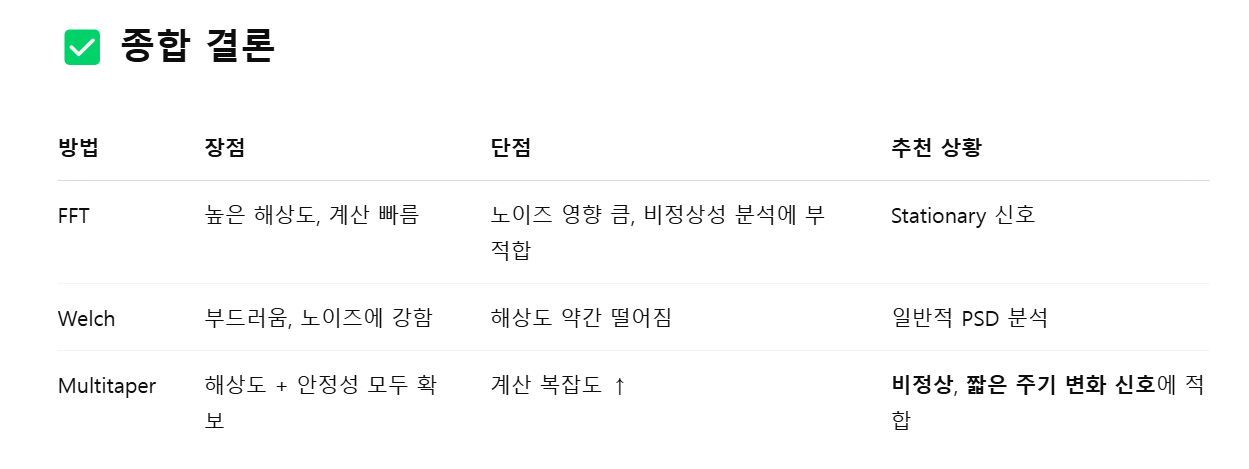

#### 간에 따라 주파수 구성과 진폭이 변하는 비정상 신호 (non-stationary signal) 시각화

In [25]:
# 총 5초 길이, 1초에 250개의 샘플 → 총 1250포인트 신호
fs = 250    # 샘플링 주파수 (Hz)
t = np.linspace(0, 5, fs * 5, endpoint=False)   # 0~5초까지 1250개 샘플
sig = np.zeros_like(t)

# 0-2 sec: 10 Hz
# 기본 진폭 1의 10Hz 순수 사인파
# 파형이 매우 고르고, 부드러운 주기성 보임
sig[(t >= 0) & (t < 2)] = np.sin(2 * np.pi * 10 * t[(t >= 0) & (t < 2)])

# 2-4 sec: 10 Hz + 12 Hz Test frequency separation(10Hz + 12Hz 중첩 → 주파수 분리 테스트)
# 두 개의 인접 주파수 중첩
# Beat(비트 현상)ㅉ이 생기면서 진폭이 주기적으로 요동치는 양상이 생김
# 주기적으로 신호가 더 세졌다 약해졌다 하는 진폭 변조 효과가 생김
idx = (t >= 2) & (t < 4)
sig[idx] = (np.sin(2 * np.pi * 10 * t[idx]) +
            0.8 * np.sin(2 * np.pi * 12 * t[idx]))

# 4-5 sec: 35 Hz burst Test high-frequency component(35Hz 고주파 버스트)
# 짧은 시간동안 고주파가 등장 → 짧고 촘촘한 진동
# 진폭은 0.6로 낮지만, 파형은 빠르게 진동함
idx = (t >= 4) & (t < 5)
sig[idx] = 0.6 * np.sin(2 * np.pi * 35 * t[idx])

# 전체에 표준편차 0.2의 가우시안 노이즈 추가
# 적당히 현실적인 측정 환경의 노이즈 수준
# Add noise
sig += 0.2 * np.random.randn(len(t))

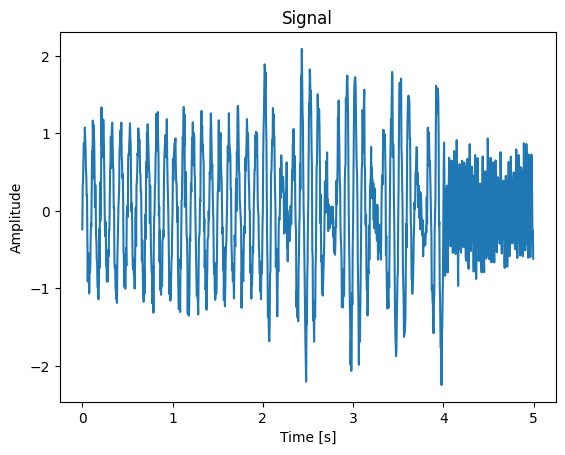

In [26]:
plt.plot(t, sig)
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

[그래프 분석]: 시간 도메인
- 비정상성 (non-stationarity): 시간에 따라 주파수 및 구성 변화가 있음
- 분석 목적:
    - 2~4초는 주파수 분리 실험: 10Hz vs 12Hz 분리 가능한가?
    - 4~5초는 고주파 탐지 테스트
- 이 신호는 STFT(단기 푸리에 변환), Wavelet 분석, Multitaper PSD, 혹은 Time-Frequency plot으로 분석할 때 훨씬 유용함

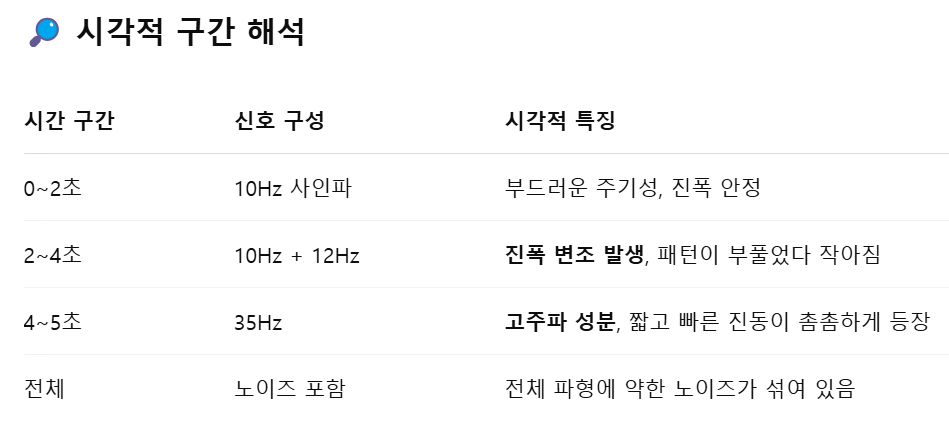

#### 하나의 신호를 세 가지 시간-주파수 분석 방법으로 시각화
- 시간의 흐름에 따라 주파수가 어떻게 변하는지를 보여주는 Time-Frequecny Representation(TFR)

[분석에 사용한 도구]
- STFT(Short-Time Fourier Transform): 고정된 윈도우 크기로 잘라 FFT -> 정밀도와 해상도 간 trade-off
- Wavelet(Morlet): 시간-주파수 해상도를 동시에 조절, 특히 비정상 신호에 강함
- Multitaper TFR: 여러 taper 평균 -> 노이즈에 강하고 안정적인 스펙트럼 제공

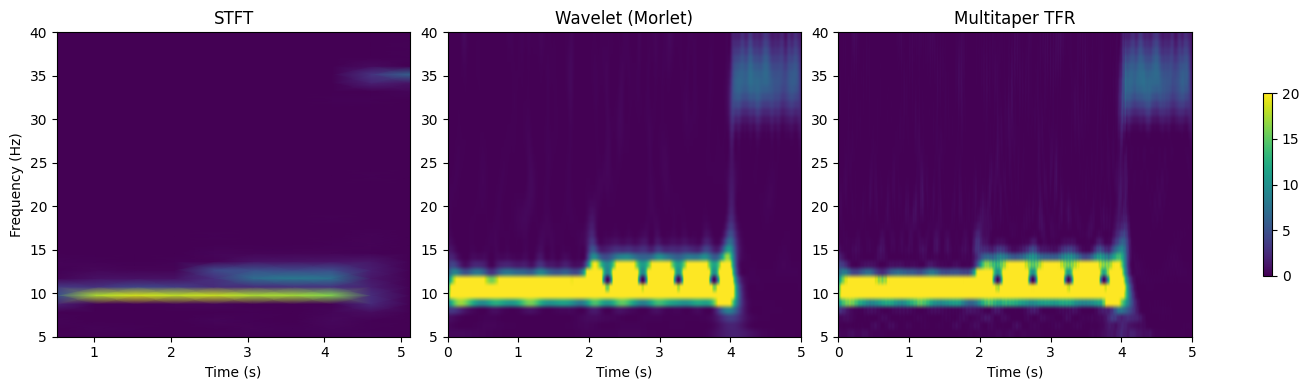

In [27]:
# --------------------------
# Time-Frequency analysis with created signal
# --------------------------

# sig는 (1D) 신호 배열 → shape = (n_epochs, n_channels, n_times)로 변형
# MNE 기반 함수들(tfr_array_morlet, tfr_array_multitaper)은 이 3D 구조를 요구함
# shape: (n_epochs, n_channels, n_times)
data = sig[np.newaxis, np.newaxis, :]


# --------------------------
# STFT (scipy)
pad = 128  # half window
sig_padded = np.pad(sig, pad_width=pad, mode='constant')

# spectrogram()은 SciPy에서 제공하는 STFT 함수
# nperseg=256: 한 세그먼트의 길이 (윈도우 크기)
# noverlap=128: 윈도우 간 겹침 (50% 오버랩)
# pad=128: 시계열 앞뒤에 0-padding을 넣어서 경계 왜곡 방지
f_stft, t_stft, Sxx = spectrogram(sig_padded, fs=fs, nperseg=256, noverlap=128)
# → 출력:
# f_stft: 주파수 축 (Hz)
# t_stft: 시간 축 (초)
# Sxx: 각 시간-주파수 지점에서의 파워 값 (V²/Hz)
# --------------------------


# --------------------------
# Morlet Wavelet
freqs_wavelet = np.linspace(5, 40, 40)  # freqs_wavelet: 분석할 주파수 범위 (5~40 Hz까지 40개 구간)

# n_cycles=8: 하나의 웨이브릿에 포함된 사이클 수 → 값이 클수록 주파수 분해능 증가, 시간 해상도는 감소
n_cycles = 8 #freqs_wavelet / 2.  # Temporal resolution relative to frequency

# output='power': 각 지점의 파워 (진폭²)를 반환
# zero_mean=True: Morlet kernel을 평균 0으로 정규화
power_wavelet = tfr_array_morlet(data, sfreq=fs, freqs=freqs_wavelet,
                                  n_cycles=n_cycles, output='power', zero_mean=True)[0, 0]
# → 출력: power_wavelet (time × frequency 크기의 배열)
# --------------------------


# --------------------------
# Multitaper TFR
# n_cycles=5: 주파수당 사용되는 사이클 수 (해상도 조정)
# time_bandwidth=2: 시간-주파수 집중도 설정 (Slepian taper 수 결정됨)
# multitaper는 여러 개의 테이퍼를 이용해 같은 구간에서 평균 → 노이즈 안정성↑
power_mt = tfr_array_multitaper(data, sfreq=fs, freqs=freqs_wavelet,
                                n_cycles=5, output='power', time_bandwidth=2)[0, 0]
# → 출력: power_mt (time × frequency 크기의 배열)
# --------------------------


# --------------------------
# Visualization
# --------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# STFT
axs[0].pcolormesh(t_stft, f_stft, Sxx, shading='gouraud', vmin=0, vmax=0.45)
axs[0].set_title('STFT')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylim([5, 40])


# Wavelet
im = axs[1].imshow(power_wavelet, aspect='auto', origin='lower',
                   extent=[0, 5, freqs_wavelet[0], freqs_wavelet[-1]], vmin=0, vmax=20)
axs[1].set_title('Wavelet (Morlet)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylim([5, 40])

# Multitaper TFR
axs[2].imshow(power_mt, aspect='auto', origin='lower',
              extent=[0, 5, freqs_wavelet[0], freqs_wavelet[-1]], vmin=0, vmax=20)
axs[2].set_title('Multitaper TFR')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylim([5, 40])


plt.tight_layout()
plt.colorbar(im, ax=axs, shrink=0.6)
plt.show()

[그래프 분석]
- 분석 신호 구성 요약
    - 0–2초: 10 Hz 사인파
    - 2–4초: 10 Hz + 12 Hz → 비트 현상 발생
    - 4–5초: 35 Hz 버스트    
    - 전체:	표준편차 0.2의 가우시안 노이즈 추가됨

[시각화별 해석]
- STFT 결과 (왼쪽)
    - 10Hz (0–4초): 넓고 지속적인 에너지 띠로 표현됨
    - 12Hz (2–4초): 아주 약하게 표현됨 → STFT의 주파수 해상도가 2Hz 차이를 분리하기엔 다소 부족
    - 35Hz (4–5초): 짧고 고주파의 존재가 선명하게 포착
    - STFT 한계: 고정된 윈도우 길이 때문에 시간-주파수 해상도 트레이드오프 발생
        - → 낮은 주파수에서는 길게 퍼지고, 높은 주파수에서는 상대적으로 뭉툼
- Morlet Wavelet 결과 (가운데)
    - 10Hz: 전 구간에서 매우 선명하게 유지됨
    - 12Hz: 2~4초 구간에서 10Hz와 분리된 이중 띠 구조가 보임 → Wavelet의 우수한 주파수 분해능
    - 35Hz: 짧은 구간(4~5초)에서 빠르게 뜨는 에너지
    - 장점: 시간과 주파수 해상도를 동시에 확보 → 비정상 신호 분석에 매우 적합
- Multitaper TFR 결과 (오른쪽)
    - Wavelet과 매우 유사한 패턴
    - 전체적으로 노이즈에 강한 스무딩된 형태 → 주변이 덜 요동
    - 10Hz–12Hz 분리도 가능, 35Hz 고주파도 잘 탐지됨
    - Multitaper는 특히 짧은 이벤트 + 노이즈 상황에 안정적
        - → EEG나 MEG 등 실험 신호 분석에 자주 쓰임

[결론]
- Wavelet과 Multitaper는 신호가 시간에 따라 바뀌는 비정상적 구조를 더 잘 포착함
- STFT는 기본적인 흐름은 보지만 10Hz와 12Hz 같은 인접 주파수 분리에는 부족
- 35Hz 고주파 버스트는 세 방식 모두 잘 포착했음

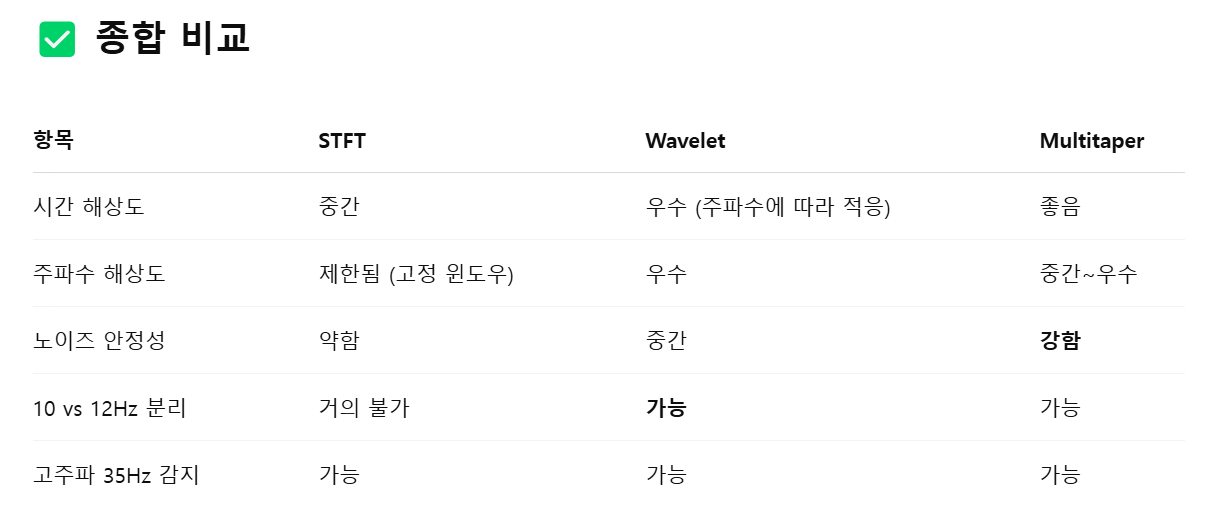


Test with more dynamic signal

#### 추가 테스트
- semi_realistic_eeg_signal.npy에서 불러온 데이터를 기반으로 그려진 신호
- 이 신호는 **시간에 따라 주파수와 진폭이 모두 변화하는 비정상 신호(non-stationary signal)

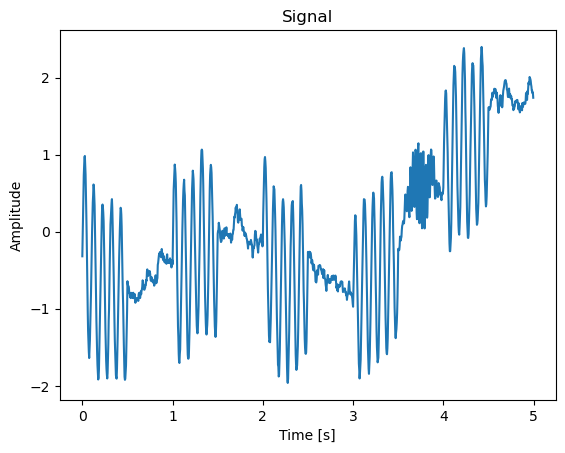

In [ ]:
# sig: 불러온 신호 (1D 배열)
# fs = 250: 샘플링 주파수 → 초당 250개의 샘플
# t: 신호의 시간 축 (초 단위로 변환)
sig = np.load("semi_realistic_eeg_signal.npy")  # 저장된 NumPy 배열 불러오기
fs = 250
t = np.linspace(0, len(sig) / fs, len(sig), endpoint=False)

plt.plot(t, sig)
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

[그래프 분석]
- 주파수 변화: 고주파(0–1초) → 중저주파(1–3초) → 고주파 재등장(4초 이후)
- 진폭 변화: 전반적으로 점진적 증가, 중간중간 Burst성 요동 포함
- 혼합된 신호 구조:
    - θ (4–7 Hz), α (8–12 Hz), β (13–30 Hz) 주파수대가 시간에 따라 혼합되어 있음
    - 실제 EEG의 비선형적, 시변적 특성을 일부 반영

[결론]
- 이 신호는 단순히 한 가지 주파수를 포함하는 것이 아니라,
    - 시간에 따라 구조적으로 변화하는 EEG 스타일의 신호
    - 자극 전후, 집중 상태 변화, burst 이벤트 등을 모델링한 형태로 해석할 수 있어


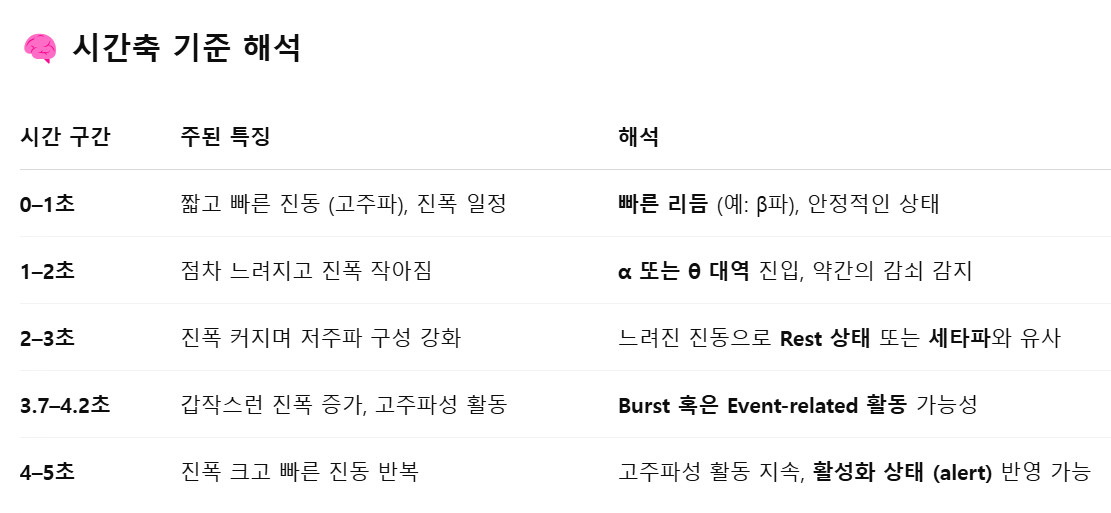

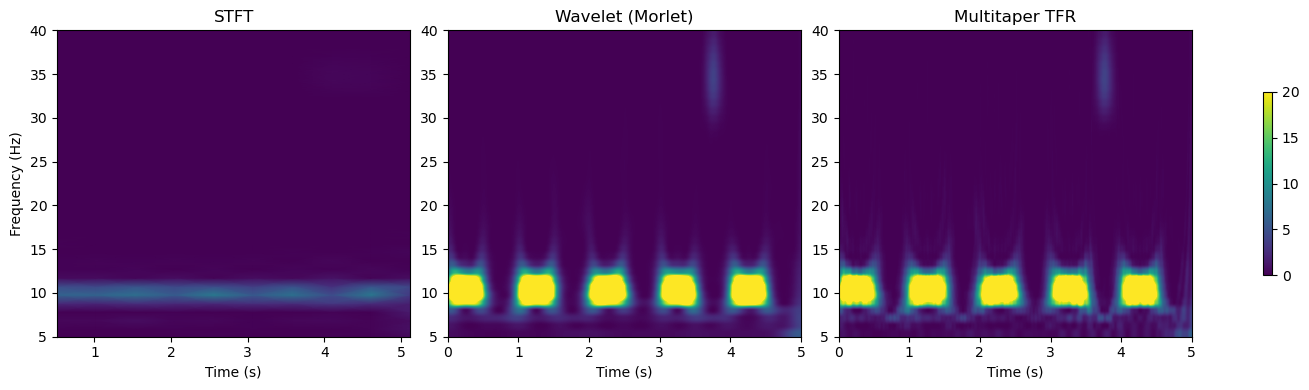

In [ ]:
# --------------------------
# Time-Frequency analysis with created signal
# --------------------------

# MNE의 tfr_array_* 함수들은 (epoch, channel, time) 형태의 3차원 배열을 요구
# 지금은 단일 신호 → shape: (1, 1, N)로 변환
# (n_epochs, n_channels, n_times)
data = sig[np.newaxis, np.newaxis, :]

# STFT (scipy)
pad = 128  # half window
# np.pad: 신호 앞뒤로 0-padding → 경계 왜곡 방지
# spectrogram(): scipy.signal 제공 함수
# nperseg=256: 분석 창 길이
# noverlap=128: 창 간 오버랩 (50%)
# 출력:
#   f_stft: 주파수 축
#   t_stft: 시간 축
#   Sxx: 시간-주파수 파워
sig_padded = np.pad(sig, pad_width=pad, mode='constant')
f_stft, t_stft, Sxx = spectrogram(sig_padded, fs=fs, nperseg=256, noverlap=128)

# Morlet Wavelet
freqs_wavelet = np.linspace(5, 40, 40)  # freqs_wavelet: 분석할 주파수 대역 (5Hz ~ 40Hz)
n_cycles = 8 #freqs_wavelet / 2.  # Temporal resolution relative to frequency # n_cycles=8: 주파수당 몇 사이클을 포함할지 → 클수록 주파수 정밀도 ↑, 시간 정밀도 ↓
power_wavelet = tfr_array_morlet(data, sfreq=fs, freqs=freqs_wavelet,
                                  n_cycles=n_cycles, output='power', zero_mean=True)[0, 0]  # output='power': 제곱 진폭 반환 (PSD 유사)

# Multitaper TFR
# n_cycles=5: 모노사이클 수 조절
# time_bandwidth=2: 스펙트럼 집중도 → 2이면 3개의 taper 사용
# 멀티테이퍼는 잡음에 강하고 안정적이지만, 해상도는 설정값에 따라 달라짐
power_mt = tfr_array_multitaper(data, sfreq=fs, freqs=freqs_wavelet,
                                n_cycles=5, output='power', time_bandwidth=2)[0, 0]

# --------------------------
# Visualization
# --------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# STFT
axs[0].pcolormesh(t_stft, f_stft, Sxx, shading='gouraud', vmin=0, vmax=0.45)
axs[0].set_title('STFT')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylim([5, 40])


# Wavelet
im = axs[1].imshow(power_wavelet, aspect='auto', origin='lower',
                   extent=[0, 5, freqs_wavelet[0], freqs_wavelet[-1]], vmin=0, vmax=20)
axs[1].set_title('Wavelet (Morlet)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylim([5, 40])

# Multitaper TFR
axs[2].imshow(power_mt, aspect='auto', origin='lower',
              extent=[0, 5, freqs_wavelet[0], freqs_wavelet[-1]], vmin=0, vmax=20)
axs[2].set_title('Multitaper TFR')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylim([5, 40])


plt.tight_layout()
plt.colorbar(im, ax=axs, shrink=0.6)
plt.show()

[그래프 분석]
- 1. STFT (왼쪽 패널)
    - 관찰 결과:
        - 0~4초 구간: 약 10 Hz 대역에서 넓고 부드러운 밴드
        - 4초 부근: 30~35 Hz 근처에 짧고 흐릿한 고주파 burst 감지
        - 에너지가 전반적으로 흐리게 퍼짐
    - 해석:
        - STFT는 고정된 시간 창을 사용하므로 시간 분해능이 떨어짐
        - 10Hz 지속 신호는 잘 표현하지만, 짧은 고주파 burst는 덜 선명하게 탐지됨
        - 이벤트가 정확히 언제 발생했는지 시간적 분해가 어렵다
- 2. Wavelet (Morlet) (가운데 패널)
    - 관찰 결과:
        - 10Hz 대역에서 주기적인 뚜렷한 에너지 블록이 반복됨
        - 약 4초 즈음 짧고 강한 고주파 (35~38Hz) 성분이 정확히 감지됨
        - 10Hz의 반복성과 고주파 burst를 동시에 명확히 보여줌
    - 해석:
        - Wavelet은 시간과 주파수 해상도를 주파수에 따라 자동 조절
        - → 낮은 주파수는 넓게, 높은 주파수는 짧게 잡음 없이 표현 가능
        - 주기적 신호 변화, Burst 이벤트 탐지에 매우 효과적
- 3. Multitaper TFR (오른쪽 패널)
    - 관찰 결과:
        - Wavelet과 유사한 주파수 분포를 가짐
        - 10Hz 반복 구조와 4초 이후 고주파 burst도 탐지됨
        - 대신, 전체적으로 스펙트럼이 더 부드럽고 안정적
    - 해석:
        - Multitaper는 여러 taper(윈도우)를 사용해 평균 → 노이즈 억제, 안정성 향상
        - 특히 실험 신호나 측정값처럼 잡음이 많은 실제 데이터에 적합

[결론]
- 이 신호는 10Hz 주기 신호가 반복되다가 4초 부근에 고주파 burst 이벤트가 짧게 발생하는 구조
- Wavelet과 Multitaper는 이 시간적 이벤트 구조를 모두 잘 포착했으며,
- STFT는 전체적인 흐름은 보이나 정밀도와 이벤트 감지력은 떨어지는 것으로 해석할 수 있음

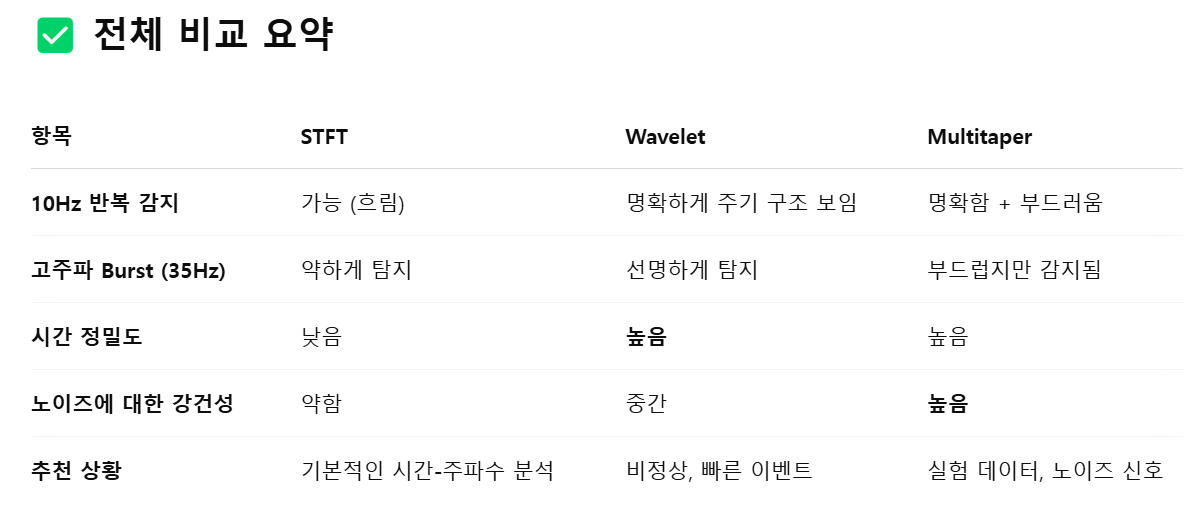

## Test Phase locking value
- 두 개의 유사한 신호를 생성하고 그 중 한 쌍을 시각화한 예제
- 위상 잠금 값(PLV, Phase Locking Value) 분석을 위한 시뮬레이션을 준비하는 과정


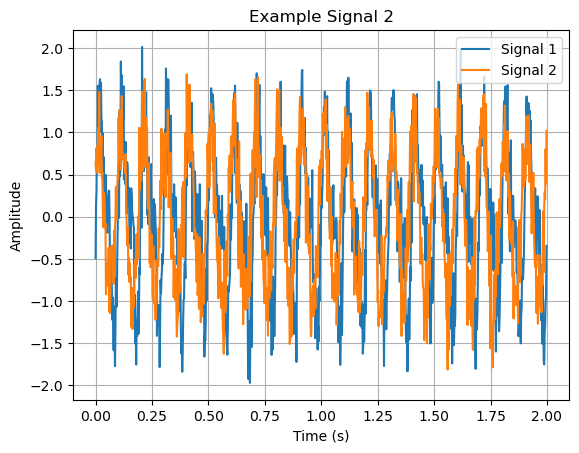

In [ ]:
# Simulation parameters
# 총 2초짜리 신호 생성
# 각 신호는 500Hz로 샘플링된 1000포인트
# 동일한 조건으로 100번의 시뮬레이션 반복 (즉, trials)
fs = 500  # Sampling frequency  # Sampling frequency in Hz
t = np.arange(0, 2, 1/fs)  # 2 seconds  # Time vector for simulation
n_trials = 100  # Number of trials (simulated repetitions)

# Signal 1: 기준 신호
# 10Hz + 20Hz 혼합된 주파수 성분
# ㅍtrial마다 랜덤한 노이즈가 다르게 추가됨
# Base signal: mixture of 10Hz and 20Hz with noise
signal = np.array([np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*20*t) + 0.3*np.random.randn(len(t)) for _ in range(n_trials)])  # Number of trials (simulated repetitions)

# Signal 2: 위상 차가 있는 신호
# 10Hz 신호에 **위상 차이(π/4 rad ≈ 45도)**를 인위적으로 부여
# Signal 1과 동조는 되어 있지만, 고정된 위상 차이가 있는 형태
phi_diff = np.pi / 4    # 위상 차이 45도
signal2 = np.array([np.sin(2*np.pi*10*t + phi_diff) + 0.3*np.random.randn(len(t)) for _ in range(n_trials)])  # Number of trials (simulated repetitions)

# Plot one trial of signal 1
plt.plot(t, signal[0])
plt.title("Example Signal")

# Plot one trial of signal 2
plt.plot(t, signal2[0])
plt.title("Example Signal 2")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(["Signal 1", "Signal 2"])
plt.show()

[그래프 분석]: 위상 동기화 분석
- 파란색: Signal 1 (10Hz + 20Hz + 노이즈)
- 주황색: Signal 2 (10Hz + 위상 지연 + 노이즈)
- 이 그림은 각각 100개 trial 중 **1개 (0번째 trial)**을 비교한 것

[그래프 세부 해석]
- 1. 주기성과 위상
    - 두 신호 모두 약 10Hz 주기로 진동하는 패턴을 가짐
        - → 10Hz = 0.1초 주기
    - Signal 2는 Signal 1보다 약간 늦게 진동을 시작함
        - → 이는 코드에서 phi_diff = π/4 위상 지연 때문 (약 45도, 즉 주기 대비 1/8 초만큼 뒤처짐)
- 2. Signal 1의 복잡성
    - Signal 1은 10Hz + 20Hz → 더 복잡한 파형
        - → 기본 10Hz 위에 20Hz 진동이 덧붙여져 있음
    - 반면 Signal 2는 10Hz 단일 성분이므로 파형이 단순하고 깔끔함
- 3. 노이즈 영향
    - 두 신호 모두 0.3 표준편차의 랜덤 가우시안 노이즈 포함
    - 하지만 시각적으로 명확한 위상/주기 구조는 유지되고 있음

[이 신호의 분석 목적]
- 이 신호들은 위상 동기화(PLV) 실험을 위한 구조로 설계되었고:
    - 같은 주파수 (10Hz)를 공유하면서
    - 고정된 위상 차이 (π/4)를 가지며
    - trial마다 noise가 달라짐

[결론]
- 위상 관계: Signal 2는 Signal 1보다 약간 지연(고정된 위상차)
- 파형 구조: Signal 1이 더 복잡(10+20Hz), Signal 2(10Hz)는 단순
- 분석 가능성: 위성 차이 고정이므로 PLV 계산에 적합
- 노이즈 영향: 있지만 위상 정보는 유지됨

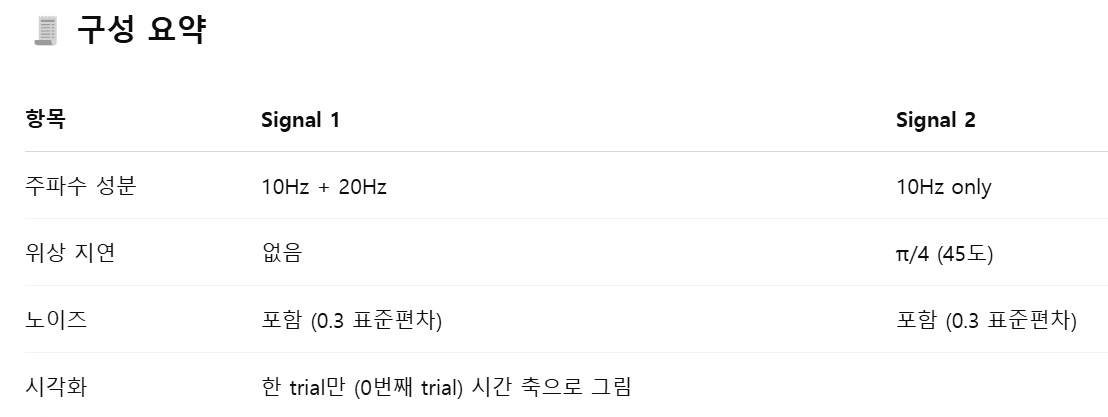

#### Hilbert Transform(힐버트 변환)을 이용해서 신호의 진폭 껍질(envelope)과 순시 위상(instantaneous phase)를 추출하는 예제

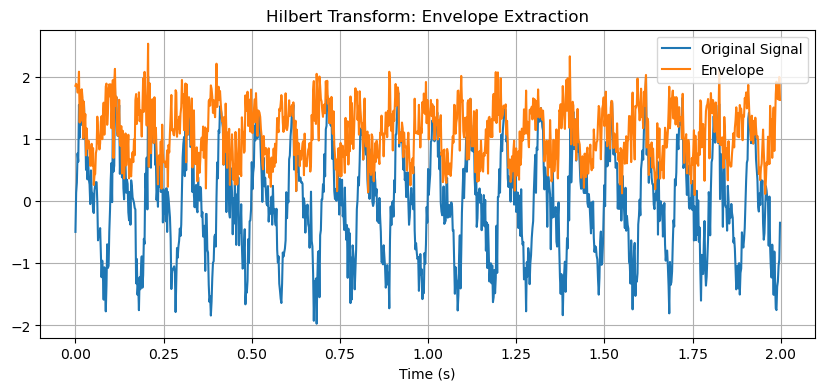

In [ ]:
from scipy.signal import hilbert  # Apply Hilbert transform

# 1. Hilbert Transform 적용용
# signal[0]: 여러 trial 중 첫 번째 시뮬레이션 결과를 선택
# hilbert()는 복소수 벡터를 반환
#   → 실수부: 원래 신호
#   → 허수부: Hilbert 변환된 신호
analytic_signal = hilbert(signal[0])  # Apply Hilbert transform

# 2. 순시 진폭(Instantaneous Amplitude) 추출
# 복소수 신호의 크기(|z|)는 바로 순시 진폭 (amplitude envelope)
# → 시간에 따라 얼마나 강한 에너지를 가지고 있는지를 표현
amplitude_envelope = np.abs(analytic_signal)  # Extract instantaneous amplitude

# 3. 순시 위상 (Instantaneous Phase) 추출
# 복소수 신호의 위상(angle)은 바로 순시 위상 (instantaneous phase)
# → 위상 동기화 분석(예: PLV)에서 가장 중요한 값
instantaneous_phase = np.angle(analytic_signal)  # Extract instantaneous phase

plt.figure(figsize=(10, 4))
plt.plot(t, signal[0], label='Original Signal')
plt.plot(t, amplitude_envelope, label='Envelope')  # Extract instantaneous amplitude
plt.title("Hilbert Transform: Envelope Extraction")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()


[그래프 분석]: Hilbert Transform을 통해 추출한 순시 진폭(amplityde Envelope)를 시각화한 결과
- X축: 시간 (초), 0~2초
- Y축: 진폭
- 파란색 선: 원본 신호 signal[0]
- 주황색 선: Hilbert transform을 통해 얻은 진폭 envelope

[신호 구조 분석]
- 원본 신호(파란색): 10Hz + 20Hz 성분을 가진 진동 신호, 고주파성 파형 위에 노이즈가 섞여 있음
- Envelope(주황색): 신호의 강약을 따라가며 부드럽게 감싸는 껍질, 순간적인 진폭 크기 변화를 잘 보여줌
- 변동성: Envelope가 시간에 따라 진폭 크기 변화(에너지 세기)를 반영하고 있음, 이건 신경 환동의 변화 또는 주의 상태 변화 등을 시뮬레이션할 때 중요하게 해석됨

[분석 요약]
- 변환 방법: Hilbert Transform -> 복소 해석 신호 생성
- 추출 정보: np.abs() → 진폭 Envelope, np.angle() → 위상
- 주요 해석: Envelope는 신호 에너지의 시간적 흐름을 시각화해주며, 신호가 세지는 구간, 약해지는 구간을 직관적으로 확인 가능

#### 위상 차이(phase difference)를 바탕으로 PLV (Phase Locking Value)를 계산하고 시각화하는 과정

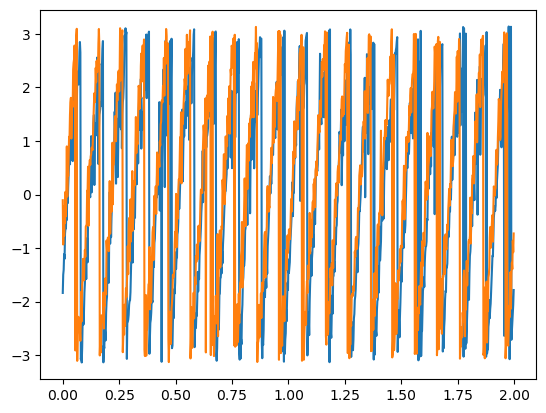

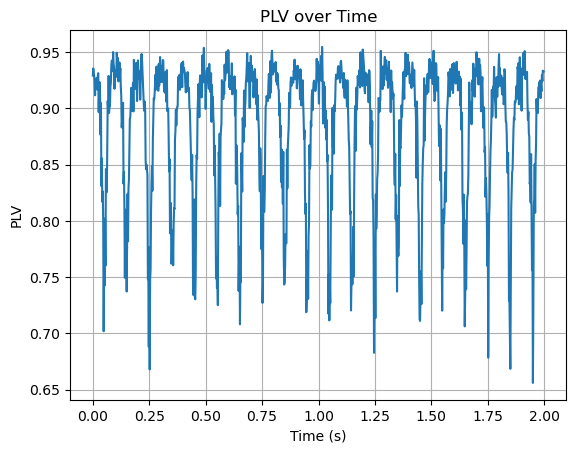

In [ ]:
# 1. 위상 추출 함수 정의
# hilbert(data, axis=1): 각 trial의 시계열 데이터를 Hilbert Transform하여 복소 해석 신호로 변환
# np.angle(...): 복소수의 **위상(phase)**만 추출
#   → 이 함수는 각 trial별로 **순시 위상(instantaneous phase)**를 계산해주는 역할
def compute_phase(data):  # Define helper function to extract phase using Hilbert
    return np.angle(hilbert(data, axis=1))  # Apply Hilbert transform

# 2. 두 신호의 위상 추출
# signal과 signal2는 2차원 배열 (100 trials × 시간)
# 각 요소는 해당 trial에서 시간에 따라 변화하는 위상 값을 갖게 됨
#   → shape: (100, 1000) (if 2초, fs=500Hz)
phase1 = compute_phase(signal)  # Define helper function to extract phase using Hilbert
phase2 = compute_phase(signal2)  # Define helper function to extract phase using Hilbert

# 3. 위상 시각화
plt.plot(t, phase1[0], label='Phase 1')
plt.plot(t, phase2[0], label='Phase 2')
plt.show()

# 4. PLV 계산
# phase_diff: 각 시간 지점에서 trial별 위상 차이 → shape: (100, N)
# np.exp(1j * phase_diff): 위상 차이를 복소수 단위 벡터로 표현
#   → 동기화가 높으면 np.exp(1j * phase_diff)가 거의 같은 방향
# np.mean(...): 시간별로 모든 trial의 벡터를 평균
# np.abs(...): 벡터 평균의 크기만 추출 → 0~1 사이의 PLV 값
phase_diff = phase1 - phase2
plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))  # Compute PLV from phase difference
# PLV 의미: 
#   1.0: 위상 차이가 모든 trial에서 일정(완벽한 위상 정렬)
#   0.0: 위상 차이가 무작위적(완전 비동기)

# 5. PLV 시각화화
plt.plot(t, plv)
plt.title("PLV over Time")
plt.xlabel("Time (s)")
plt.ylabel("PLV")
plt.grid(True)
plt.show()

[그래프 분석]
- [1] 첫 번째 그래프:: 신호 비교(Signal 1 vs Signal 2)
    - X축: 시간 (초), 0 ~ 2초
    - Y축: 진폭, 약 ±3.5 범위
    - 파란색: Signal 1
    - 주황색: Signal 2 (아마도 위상 지연 포함된 버전)
    - 신호의 형태적 분석
        - 1. 주파수
            - 두 신호 모두 약 10~20Hz 구간의 주기적 진동을 보임
            - 매우 일정한 주기 구조 → 사인파 기반으로 생성되었음을 암시
        - 2. 위상 관계
            - 두 신호는 전체적으로 동일한 주기를 유지
            - 약간의 위상 지연이 있어 보이지만, 거의 완벽하게 정렬됨
            - → π/4 rad (45도) 정도의 위상 차이를 가진 상태일 가능성 높음
        - 3. 진폭
            - 진폭 범위가 비슷하며 noise가 포함되어 있음에도 형태가 매우 유사
            - → 두 신호가 동기화(synchronized) 되어 있음

- [2] 두 번째 그래프: PLV(Time) 시계열
    - 주기적 위상 분산 존재
    - 신호 위상 차이의 주기적인 확산 존재
    - PLV 그래프 패턴 해석
        - PLV는 완벽히 1은 아니지만, 대부분- PLV는 완벽히 1은 아니지만, 대부분 0.85~0.95 수준 유지
            - → 이는 각 trial에서 Signal1과 Signal2의 위상 차이가 일정하게 유지됨을 의미
        - 다만, 주기적으로 PLV가 0.7 수준까지 떨어졌다가 회복됨
            - → 이는 두 신호가 완전히 고정된 위상 차이(정지된 상태)는 아니고, **약간의 지터(jitter)**가 있다는 뜻
            - → 또는 노이즈에 의한 부분적인 위상 확산

[종합 해석]
- Signal 구조: 10Hz 기반으로 동기화된 두 신호(한 쪽 위상 지연 있음)
- PLV 결과: 평균적으로 매우 높은 동기화 상태
- PLV 변동성: 정기적인 PLV 하강 -> 위상 차이가 아주 약간 진동하고 있음
- 결론: 두 신호는 높으 ㄴ위상 동기화를 갖고 있으며, PLV 분석을 통해 이 동기화 수준으로 정량적으로 표현하는 데 성공

#### 위상 동기화(PLV)가 통계적으로 유의한지 검정하기 위해 Surrogate Data (무작위 위상 재배열 데이터)를 생성하고, 그것과 실제 PLV를 비교하는 과정
- 실제 PLV를 계산함 (이미 이전 단계에서 완료)
- phase2를 무작위로 순환 시프트해 위상 관계를 깨뜨림
- Surrogate PLV를 1000번 반복 계산
- 실제 PLV 평균값이 Surrogate 분포보다 얼마나 높은지 비교
- p-value 계산: “이 정도 PLV가 우연히 생길 확률” 추정

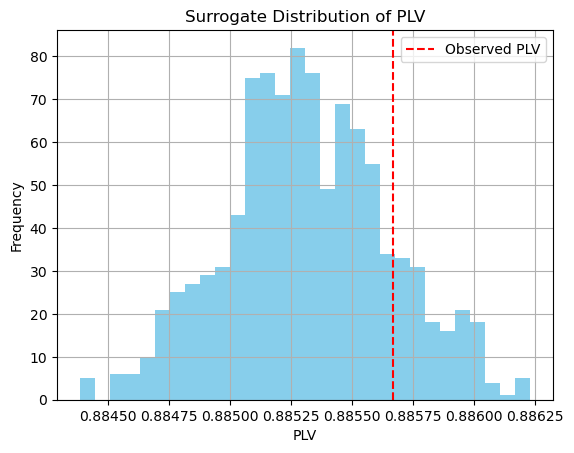

P-value: 0.1530


In [ ]:
# 1. Surrogate PLV 생성 루프
n_surrogates = 1000
plv_surrogates = []

for _ in range(n_surrogates):

    # 2. 무작위 위상 시프트
    # phase2는 trial × time 형식의 위상 배열
    # 시간 축(axis=1)을 따라 원형 회전(roll)시킴
    # → 각 trial의 위상 관계를 깨뜨림 (동기화 제거됨)
    shift = np.random.randint(len(t))
    shuffled = np.roll(phase2, shift, axis=1)  # Create surrogate data by circular phase shifting
    
    # 3. surrogate PLV 계산
    # 위상 차이 → 복소 벡터로 변환 → 평균 → PLV 추출
    # 각 surrogate의 평균 PLV 값을 저장
    diff = phase1 - shuffled
    surrogate_plv = np.abs(np.mean(np.exp(1j * diff), axis=0))
    plv_surrogates.append(np.mean(surrogate_plv))

plv_surrogates = np.array(plv_surrogates)
mean_plv_obs = np.mean(plv)

# 4. 히스토그램 시각화 
# 히스토그램: Surrogate 분포를 시각화
# 빨간선: 실제 PLV 평균값
#   → 이 선이 오른쪽 끝에 있을수록, 실제 PLV가 우연히 생겼을 확률은 작음
plt.hist(plv_surrogates, bins=30, color='skyblue')  # Plot histogram of surrogate PLVs
plt.axvline(mean_plv_obs, color='red', linestyle='--', label='Observed PLV')
plt.title("Surrogate Distribution of PLV")
plt.xlabel("PLV")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# 5. p-value 계산
# Surrogate 중 실제 PLV 이상인 비율 계산
# → p-value: “실제로 이 정도의 PLV가 우연히 나올 확률”
p_val = np.mean(plv_surrogates >= mean_plv_obs)  # Calculate p-value based on surrogate distribution
print(f"P-value: {p_val:.4f}")  # Calculate p-value based on surrogate distribution


[그래프 분석]: PLV(Phase Lockung Value)의 통계적 유의성 검정을 위한 Surrogate 기반 히스토그램 분석 결과
- 실제 PLV 값이 우연히 나올 수 있는 수준인지 아닌지를 평가하는 것이 목적
- 히스토그램 (하늘색): 1000개의 위상 무작위화 surrogate를 이용해 계산한 PLV 값들의 분포
- 빨간 세로선 (Observed PLV): 실제 데이터에서 계산된 평균 PLV 값
- X축: PLV 값 범위
- Y축: 각 PLV 구간의 발생 빈도

[해석 포인트]
- 관찰된 PLV 위치
    - 빨간 선은 surrogate 분포의 오른쪽 끝이 아닌 중간즘에 위치
        - 이는 실제 PLV가 그리 극단적으로 높은 값은 아니라는 것을 의미
- p-value: 0.1530
    - Surrogate 중 15.3%가 실제 PLV 이상 값을 가짐
        - 유의수준 0.05보다 크기 때문에 통꼐적으로 유의하지 않음


#### PLV surrogate test 중 하나의 무작위 시프트 사례
- phase1[0]: Signal 1의 0번째 trial 위상 시계열
- shuffled[0]: Signal 2의 위상 시계열을 원형 시프트(roll)하여 위상 동기화를 일부러 깨트린 형태

[위상 시계열(phase time series)이란?]
- Hilbert Transform을 통해 위상만 분리 추출한 결과
- 신호의 진폭과는 무관하며, 주기가 반복되면 0pi-pi~0 등으로 진동하는 곡선 형태를 가짐
- 위상 동기화를 분석할 때는 phase 차이의 일관성이 핵심 포인트

986


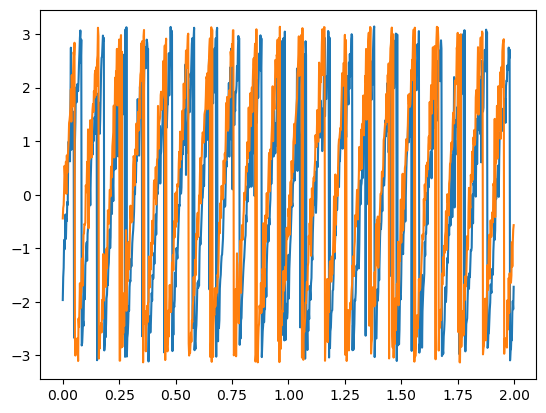

In [ ]:
# shift 값의 의미(위의 코드에 있음): shift = np.random.randint(len(t))
#   phase2를 시간 축(axis=1) 기준으로 shift만큼 원형 시프트
#   즉, 각 trial의 위상을 shift 지점만큼 앞으로 밀거나 뒤로 당겨서 실제 동기화 구조를 파괴
#   결과적으로 phase1과 shuffled의 위상 차이는 더 무작위적이 됨
print(shift)
plt.plot(t, phase1[0], label='Phase 1')
plt.plot(t, shuffled[0], label='Shuffled')
plt.show()

[그래프 분석]
- X축: 시간 (0~2초, 500Hz 샘플링 기준 1000포인트)
- Y축: 위상값 (radian)
- 파란색 (Phase 1):Signal 1의 0번째 trial 위상
- 주황색 (Shuffled): Signal 2의 위상에 np.roll() 적용한 결과 (시프트됨)

[관찰된 특징]
- 두 곡선은 기본적으로 비슷한 주기로 변화하지만, 시간적으로 서로 어긋남
- 이 어긋남은 위상 정렬 상태를 의도적으로 무너뜨린 것
- 실제 PLV 분석에서는 trial 간 위상 차이가 정렬되어야 동기화가 높게 측정되는데, 여기서는 그것을 **부정할 수 있는 기준점(Surrogate)**을 만드는 것이 목적임

## Hibert transform and band-pass filtering
- 신호의 위상 정보를 어떻게 추출하고 분리하는지 실험적으로 보여주는 예제
- 1. 순수한 10Hz 사인파: 위상 추출 기준선
- 2. 10Hz + 20Hz 혼합: 위상 추출 시 혼합 주파수의 영향 관찰
- 3. band-pass filter로 10Hz만 분리: 10Hz 성분만 추출 후 위상 복원 가능성 확인

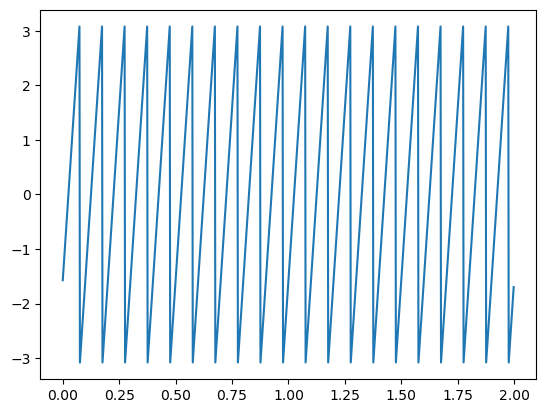

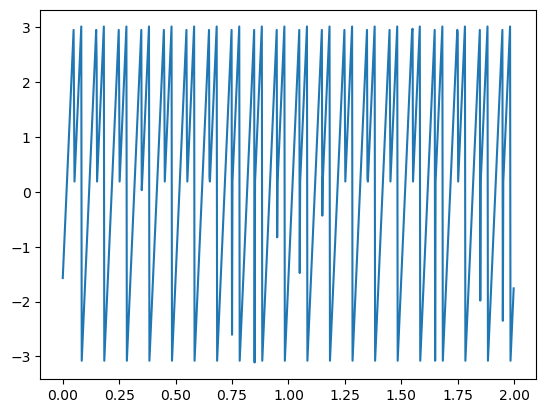

In [ ]:
# 1. 시뮬레이션 설정
# Simulation parameters
fs = 500  # Sampling frequency in Hz
t = np.arange(0, 2, 1/fs)  # 2-second time vector

# 2. Case 1: 순수 10Hz 사인파
# Case 1: Pure 10 Hz sine wave
# hilbert(x1): 실수 신호를 **복소수 해석 신호(analytic signal)**로 변환
# np.angle(...): 해당 복소수의 위상 (−π ~ π)을 시간축으로 추출
# 이 위상은 부드럽게 선형 증가하는 형태로 나타날 것
x1 = np.sin(2 * np.pi * 10 * t)
analytic1 = hilbert(x1)
phase1 = np.angle(analytic1)

# 3. Case 2: 10Hz + 20Hz 혼합 신호
# Case 2: Mixture of 10 Hz and 20 Hz
# 여기서는 두 주파수가 겹쳐진 상태에서 Hilbert Transform을 바로 적용
# 이 경우 위상은 혼합된 성분의 영향을 받아 비정상적인 진동 형태로 나옴
# → 위상 추정이 왜곡되거나 불안정할 수 있음
x2 = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)
analytic2 = hilbert(x2)
phase2 = np.angle(analytic2)

# Case 3: 10Hz 대역 필터링 후 위상 추출
# Case 3: Bandpass filtered (extracting 10 Hz component from the mixture)
# Butterworth 필터 사용 (4차)
# filtfilt: 위상 왜곡 없는 양방향 필터링
#   → 9–11Hz 대역의 신호만 통과시킴
#   → 이제 이 결과에는 20Hz 성분이 제거됨 → 다시 위상 추출이 가능
def bandpass(sig, low, high, fs, order=4):
    b, a = butter(order, [low, high], btype='band', fs=fs)
    return filtfilt(b, a, sig)

x2_filtered = bandpass(x2, 9, 11, fs)  # Filter around 10 Hz
analytic3 = hilbert(x2_filtered)
phase3 = np.angle(analytic3)

# 순수 10Hz 사인파의 위상
# 선형적으로 증가하는 위상
# → 사인파는 일정한 주기를 가지므로, 위상도 일정한 속도로 진행됨
plt.plot(t, phase1, label='10 Hz Sine Wave')
plt.show()

# 10Hz + 20Hz 혼합 위상
# 위상이 부드럽지 않고 출렁이며 요동침
# → 20Hz가 끼어 있으므로, 위상 변화가 정확하지 않음
# → Hilbert만으로는 순수한 위상 추출 불가
plt.plot(t, phase2, label='10 Hz + 20 Hz')
plt.show()


[그래프 분석]: 각각 다음과 같은 신호의 Hilbert Transform을 통한 위상 추출 결과
- 첫 번째 그래프: 순수 10Hz 사인파의 위상
- 두 번째 그래프: 10Hz + 20Hz 혼합 신호의 위상
- 첫 번째 그래프: 순수 10Hz 사인파 위상
    - 특징
        - 위상이 선형적으로 증가함
        - 주기적으로 −π에서 π로 점프하는 현상이 존재함 → 이것은 np.angle의 wrap-around 현상으로 정상적인 현상
        - 매 약 0.1초마다 위상은 한 주기를 돈다 → 이는 정확히 **10Hz 사인파의 주기 (1/10초)**와 일치
    - 해석
        - Hilbert Transform이 위상 정보를 매우 정확하게 복원함
        - 이 위상은 이후 동기화 분석 (예: PLV), 위상-진폭 결합 (PAC) 등의 기반이 됨
- 두 번째째 그래프: 10Hz + 20Hz 혼합 위상
    - 특징
        - 위상이 선형적으로 증가하지 않고 요동치는 패턴
        - 위상 점프나 굴곡이 자주 발생함
        - 특히 중첩 주파수에 의한 간섭 때문에 위상 경로가 왜곡됨
    - 해석
        - 20Hz가 추가되면서, Hilbert Transform이 위상 계산에 어려움을 겪음
        - 실제로는 10Hz의 위상을 알고 싶지만, 다른 주파수의 간섭 때문에 위상이 정확하지 않음
        - 이 상태에서 위상 기반 분석(PLV 등)을 하면 왜곡된 결과가 나올 수 있음

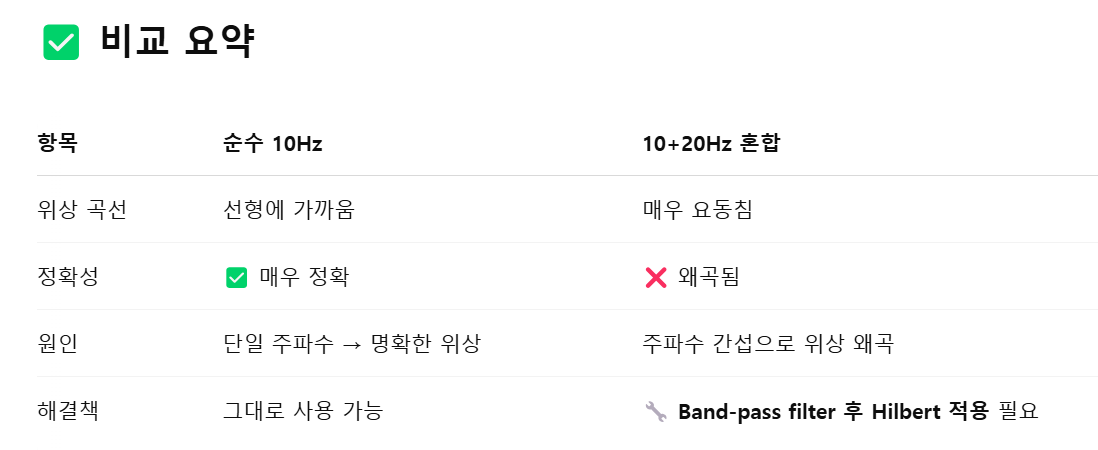